In [1]:
#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # needed for heatmap
from os.path import join
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
plt.rcParams['figure.figsize'] = [7, 5]

In [2]:
# define paths for data
FOLDER_PATH = 'data'
PURCHASES_PATH = 'area_level_purchases'
OSWARD_GROCERY = 'year_osward_grocery.csv'
WARD_ATLAS = 'ward-atlas-data.csv'

ward_data_path = join(FOLDER_PATH, PURCHASES_PATH, OSWARD_GROCERY)
atlas_data_path = join(FOLDER_PATH, WARD_ATLAS)

# load the data sets
df_ward = pd.read_csv(ward_data_path, sep=',', index_col=0)
df_atlas = pd.read_csv(atlas_data_path, sep=',', encoding='iso-8859-1')

# Preprocessing

In [3]:
def drop_redundant_data(df_atlas):
    # clean age (columns after 2013 are projections, therefore keep 2013 columns)
    cond = df_atlas.columns.str.startswith('Population and Age') & ~df_atlas.columns.str.contains('2013')
    df_atlas = df_atlas.loc[:, ~cond]
    # drop absolute population values
    df_atlas = df_atlas.drop(['Population and Age; Population Estimates and Projections; 2013',
                   'Population and Age; Aged 0-15; 2013',
                   'Population and Age; Aged 16-64; 2013',
                   'Population and Age; Aged 65+; 2013',
                   'Population and Age; All ages; 2013',
                   'Population and Age; Mean age; 2013',
                   'Population and Age; Median age; 2013'], axis=1)
    # delete population density
    cond = df_atlas.columns.str.startswith('Area and Density')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete the 18 ethnic groups for now, as they add complexity
    cond = df_atlas.columns.str.startswith('Diversity; Ethnic Group 18 groups')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household language (of no interest) 
    cond = df_atlas.columns.str.startswith('Diversity; Household Language - 2011 Census')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household composition data
    cond = df_atlas.columns.str.startswith('Household composition')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household repossesion
    cond = df_atlas.columns.str.startswith('Home repossessions')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated birth and death markers
    cond = df_atlas.columns.str.startswith('Births and deaths')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated life expectancy
    cond = df_atlas.columns.str.startswith('Life Expectancy')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated housing markers
    cond = df_atlas.columns.str.startswith('Housing type and Tenure')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('House Prices')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete tax related data (not of interest)
    cond = df_atlas.columns.str.startswith('Dwellings and Council tax')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete dwelling data which is not of interest
    cond = df_atlas.columns.str.startswith('Property Type') | df_atlas.columns.str.startswith('Size of dwellings') | df_atlas.columns.str.startswith('Property build period')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated income data
    cond = df_atlas.columns.str.startswith('Household Income') & ~df_atlas.columns.str.contains('2012/13')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated employment data
    cond = df_atlas.columns.str.startswith('Employment')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete benefits claimants and jobseekers allowance
    cond = df_atlas.columns.str.startswith('Benefits claimants') | df_atlas.columns.str.startswith('Jobseekers Allowance')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete out of work families
    cond = df_atlas.columns.str.startswith('Out-of-Work Families')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated poverty
    cond = df_atlas.columns.str.startswith('Children in Poverty')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated "intelligence" scores
    cond = df_atlas.columns.str.startswith('GCSE')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('A-Level Point Scores')
    df_atlas = df_atlas.loc[:, ~cond]
    # pupil abscence not if interest
    cond = df_atlas.columns.str.startswith('Pupil Absence')
    df_atlas = df_atlas.loc[:, ~cond]
    # individual crimes not of interest, only crime rate
    cond = df_atlas.columns.str.startswith('Crime') # & ~df_atlas.columns.str.contains('Total crime rate; 2014/15')
    df_atlas = df_atlas.loc[:, ~cond]
    # further columns not of interest
    cond = df_atlas.columns.str.startswith('Fires') | df_atlas.columns.str.startswith('Ambulance') \
    | df_atlas.columns.str.startswith('Binge Drinking') | df_atlas.columns.str.startswith('Road Casualties') \
    | df_atlas.columns.str.startswith('Air Emissions') | df_atlas.columns.str.startswith('Land Use') \
    | df_atlas.columns.str.startswith('Access to green space and nature') | df_atlas.columns.str.startswith('Public Transport Accessibility')\
    | df_atlas.columns.str.startswith('Car access') | df_atlas.columns.str.startswith('Travel to work by bicycle') \
    | df_atlas.columns.str.startswith('Workplace employment') | df_atlas.columns.str.startswith('Nat Insurance No. registrations') \
    | df_atlas.columns.str.startswith('Election turnout')
    df_atlas = df_atlas.loc[:, ~cond]
    # obesity already available in cleaned format
    cond = df_atlas.columns.str.startswith('Childhood Obesity Prevalence')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete old indices of deprivation
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.contains('2010')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.endswith('Average Score; 2010')
    df_atlas = df_atlas.loc[:, ~cond]
    
    df_atlas.drop('Unnamed: 0', axis=1, inplace=True)
    df_atlas.drop(df_atlas.index[-3:], inplace=True)
    df_atlas.drop(df_atlas.index[0], inplace=True)
    return df_atlas

df_atlas = drop_redundant_data(df_atlas)

In [4]:
# The first 4 columns seem to have a wrong name
df_atlas.rename(columns={'Unnamed: 1': 'New Code', 'Unnamed: 2': 'Borough', 
                         'Unnamed: 3': 'Names'}, inplace=True)

# very long column names, rename columns to more concise names
import re
rename_map = {name: re.sub('.*; ', '', name) for name in df_atlas.columns.values}
# after inspection 'Household Income; Median Modelled Household income (£); 2012/13',
# 'Household Income; Mean Modelled Household income (£); 2012/13',
# 'Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; ',
# and 'Indices of Deprivation; Average Score; 2010' have been replaced too much, manually add those column names
rename_map['Household Income; Median Modelled Household income (£); 2012/13'] = 'Household Income Mean'
rename_map['Household Income; Mean Modelled Household income (£); 2012/13'] = 'Household Income Median'
rename_map['Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; '] = 'Well-Being'
rename_map['Indices of Deprivation; Average Score; 2010'] = 'IOD AVG'
df_atlas.rename(columns=rename_map, inplace=True)
                         
df_atlas.rename(columns={'% No qualifications': 'No qualifications', 
                         '% Highest level of qualification: Level 1 qualifications': 'Level 1 qualifications', 
                         '% Highest level of qualification: Level 2 qualifications': 'Level 2 qualifications', 
                         '% Highest level of qualification: Apprenticeship': 'Apprenticeship qualifications', 
                         '% Highest level of qualification: Level 3 qualifications': 'Level 3 qualifications', 
                         '% Highest level of qualification: Level 4 qualifications and above': 'Level >=4 qualifications',
                         '% Highest level of qualification: Other qualifications': 'Other qualifications', 
                         '% People with Bad or Very Bad Health': 'Bad Health',
                         '% People whose Day-to-day activities are limited a lot': 'Limited activities'},
                inplace=True)

In [5]:
# to numeric conversion
df_atlas.loc[:, 'Aged 0-15':] = df_atlas.loc[:, 'Aged 0-15':].apply(pd.to_numeric, errors='coerce')

In [6]:
age_cols = ['Aged 0-15', 'Aged 16-64', 'Aged 65+'] #sum to 1
ethnicities_cols = ['White', 'Mixed', 'Asian or Asian British', 'Black or Black British', 'Other'] #sum to 1
religion_cols = ['Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh',
       'No religion', 'Other religions', 'Religion not stated'] # sum to 1
born_cols = ['Born in UK', 'Not Born in UK'] # sum to 1
wealth_cols = ['Household Income Median', 'IOD AVG'] #'Well-Being'
qualilication_cols = ['No qualifications', 'Level 1 qualifications', 'Level 2 qualifications',
       'Apprenticeship qualifications', 'Level 3 qualifications',
       'Level >=4 qualifications', 'Other qualifications'] # sum to 1 
disability_cols = ['Bad Health', 'Limited activities']
all_features = age_cols + ethnicities_cols + religion_cols + born_cols + wealth_cols + qualilication_cols + disability_cols

In [8]:
def normalize(df, cols):
    total = df[cols].sum(axis=1)
    df[cols] = df[cols].div(total, axis=0)
    return df

def standartize(df, cols):
    means = df[cols].mean()
    stds = df[cols].std()
    df[cols] = (df[cols] - means) / stds
    return df

def min_max_scaling(df, cols):
    mins = df[cols].min()
    maxs = df[cols].max()
    df[cols] = (df[cols] - mins) / (maxs - mins)
    return df

In [9]:
#normalize
df_atlas[age_cols] /= 100
df_atlas = normalize(df_atlas, ethnicities_cols)
df_atlas = normalize(df_atlas, religion_cols)
df_atlas = normalize(df_atlas, born_cols)
df_atlas[qualilication_cols] /= 100

In [10]:
df_atlas['Household Income Median'] = df_atlas['Household Income Median'].apply(np.log)
df_atlas = standartize(df_atlas, wealth_cols)

In [11]:
df_atlas = standartize(df_atlas, disability_cols)

In [12]:
important_cols = ['weight', 'volume', 'fat', 'saturate', 'salt', 'sugar', 'protein', 'carb',
                 'fibre', 'alcohol', 'energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot', 'f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol', 
                 'energy_density', 'h_nutrients_weight', 'h_nutrients_weight_norm', 'h_nutrients_calories',
                  'h_nutrients_calories_norm', 'representativeness_norm']

In [13]:
df_atlas.set_index('New Code', drop=True, inplace=True)

In [ ]:
# merge the data sets by ward
df_ward_atlas = pd.merge(df_ward[important_cols], df_atlas, how='inner', left_index=True, right_index=True, validate='1:1')

In [15]:
df_ward_atlas.head(1)

,weight,volume,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,Level 2 qualifications,Apprenticeship qualifications,Level 3 qualifications,Level >=4 qualifications,Other qualifications,% of 16+ who are schoolchildren and full-time students: Age 18 and over,Bad Health,Limited activities,Well-Being,IOD AVG
E05000026,449.535137,125.960833,9.488797,3.693721,0.58324,10.966213,4.97756,19.381951,1.564721,0.198172,...,0.115,0.011,0.085,0.345,0.167,14.3,-0.492858,-1.121216,7.897959,0.694138


In [16]:
target_cols = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']

# Separate predictions

In [27]:
from sklearn.metrics import r2_score

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression

def Train_model(Model,x_data,y_data):
    X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size = 0.2)
    Model.fit(X_train,y_train)
    y_pred=Model.predict(X_test)
    return Model,r2_score(y_test,y_pred)

In [28]:
x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[target_cols]
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

## Linear regression

In [29]:
Linear_models={}
Linear_scores=[]
df_Scores=pd.DataFrame(columns=y_data.columns.values)

for i,column in enumerate(y_data.columns.values):
    Model,R_2=Train_model(LinearRegression(),x_data,y_data[column])
    Linear_models[column]=Model
    Linear_scores.append(R_2)

df_Scores.loc['Linear Regression R^2']=Linear_scores
df_Scores

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot
Linear Regression R^2,0.23636,0.24976,0.403996,0.605033,0.657281,0.593942,0.307523,0.675526


## Gradient boosting

In [30]:
GradientB_models={}
GradientB_scores=[]

for i,column in enumerate(y_data.columns.values):
    Model,R_2=Train_model(GradientBoostingRegressor(random_state=0),x_data,y_data[column])
    GradientB_models[column]=Model
    GradientB_scores.append(R_2)
    
df_Scores.loc['Gradient Boosting R^2']=GradientB_scores
df_Scores

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot
Linear Regression R^2,0.236360,0.249760,0.403996,0.605033,0.657281,0.593942,0.307523,0.675526
Gradient Boosting R^2,0.321321,0.302523,0.416680,0.662945,0.741789,0.701922,0.336987,0.617522


### Searching for optimal Gradient boosting parameters

In [31]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

parameters={'n_estimators':range(50,350,50),
           'learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]}

GradientB_adjusted_models={}
GradientB_scores=[]

for i,column in tqdm(enumerate(y_data.columns.values)):
    G_search=GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
                     param_grid=parameters, scoring='r2',iid=False,cv=5)
    G_search.fit(X_train,y_train[column])
    Model=G_search.best_estimator_
    R_2=r2_score(y_test[column],Model.predict(X_test))
    GradientB_adjusted_models[column]=Model
    GradientB_scores.append(R_2)
    
df_Scores.loc['Gradient Boosting adjusted R^2']=GradientB_scores
df_Scores

8it [06:10, 45.50s/it]


,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot
Linear Regression R^2,0.236360,0.249760,0.403996,0.605033,0.657281,0.593942,0.307523,0.675526
Gradient Boosting R^2,0.321321,0.302523,0.416680,0.662945,0.741789,0.701922,0.336987,0.617522
Gradient Boosting adjusted R^2,0.316831,0.399683,0.590850,0.631500,0.781374,0.537209,0.460622,0.679322


## Unifying the best models

In [34]:
Architectures=[Linear_models,GradientB_models,GradientB_adjusted_models]
Optimal_Models={}
Optimal_Scores=[]

for i,column in tqdm(enumerate(y_data.columns.values)):
    #Choose architecture with the highest R^2 for a given label
    #[-1] means that if two models have the same score, we would chose adjusted one
    Number_of_optimal_architecture=np.where(
        df_Scores[column]==df_Scores[column].max())[0][-1]
    #Assign optimal model for given label with this model
    Optimal_Models[column]=Architectures[Number_of_optimal_architecture][column]
    Optimal_Scores.append(df_Scores[column][Number_of_optimal_architecture])

df_Scores.loc['Optimal model R^2']=Optimal_Scores
df_Scores.loc['Optimal model R^2']

8it [00:00, 552.42it/s]


energy_fat         0.321321
energy_saturate    0.399683
energy_sugar       0.590850
energy_protein     0.662945
energy_carb        0.781374
energy_fibre       0.701922
energy_alcohol     0.460622
energy_tot         0.679322
Name: Optimal model R^2, dtype: float64

# Neural network

In [42]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Input
from tensorflow.keras import layers
from tensorflow.keras.losses import KLDivergence

import matplotlib.pyplot as plt
def Training_curve(history,start_epoch=0):
    loss=history.history['loss'][start_epoch:]
    val_loss=history.history['val_loss'][start_epoch:]
    epochs=np.arange(len(loss))+start_epoch
    plt.plot(epochs,loss,label='train loss')
    plt.plot(epochs,val_loss,label='test loss')
    plt.title('Training curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')

In [48]:
target_cols = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']

x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[target_cols]
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [49]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(X_train.shape[1], kernel_initializer='normal'
                , activation='relu'))
model.add(Dense(y_train.shape[1], ))
model.compile(optimizer='sgd', 
              loss='mean_squared_error')

In [50]:
history = model.fit(x_data, y_data, epochs=200,
          validation_split=0.2, verbose=0)

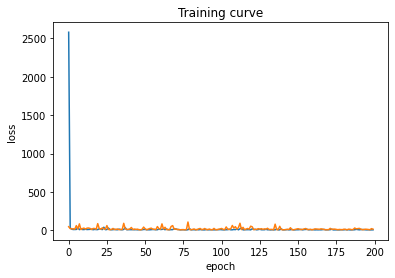

In [51]:
Training_curve(history)

In [53]:
print('Last validation MAE {:.4f}'.format(
    history.history['val_loss'][-1]))

Last validation MAE 14.6916


## predicting distribution

In [35]:
target_cols = ['f_energy_fat', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']

x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[target_cols]
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [39]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer='sgd', 
              loss=KLDivergence(), 
              metrics=['mean_absolute_error'])

In [40]:
history = model.fit(x_data, y_data, epochs=200,
          validation_split=0.2, verbose=0)

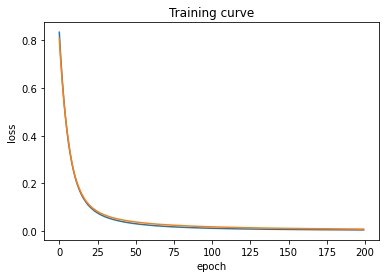

In [43]:
Training_curve(history)

In [47]:
print('Last validation MAE {:.4f}'.format(
    history.history['val_mean_absolute_error'][-1]))

Last validation MAE 0.0172
